In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# LSTM-based water level prediction

## Data import and cleaning

In [196]:
def changeTimeZone(row):
    if row[-3] == 'EST':
        row[0] = row[0] + pd.to_timedelta(1, unit='h')
        row[-3] = 'EDT'
    return row

def dataImport(addr, skiprows):
    data = pd.read_csv(addr, skiprows = np.arange(skiprows), delimiter = '	', names = ['USGS', 'code', 'time', 'timeZone', 'value', 'provisional']) 
    data = data.drop(['USGS', 'code'], axis = 1)
    data['time'] = pd.to_datetime(data['time'])
    data = data.apply(changeTimeZone, axis = 1)
    data = data.set_index('time')
    data = data.reindex(pd.date_range(start = data.index[0], end = data.index[-1], freq='15min'))
    data = data.loc[:'2021-10-19 09:00:00']
    data = data.interpolate()
    data = data.reset_index()
    return data

data_waterLevel = dataImport('./data/waterLevel.txt', 29)
data_precipitation = dataImport('./data/precipitation.txt', 29)
data_discharge = dataImport('./data/discharge.txt', 30)
data = pd.concat([data_waterLevel.value, data_precipitation.value, data_discharge.value], axis = 1)
data = data.set_axis(['waterLevel', 'precipitation', 'discharge'], axis = 1, inplace = False)

## Data preprocessing

In [143]:
# params
train_split_fraction = 0.7
val_split_fraction = 0.15
past = 28
predict_length = 2
learning_rate = 0.001
batch_size = 256
epochs = 25

# split data
train_split = int(train_split_fraction * int(data.shape[0]))
val_split = int(val_split_fraction * int(data.shape[0]))
train_data = data.loc[0 : train_split - 1]
val_data = data.loc[train_split : (train_split + val_split - 1)]
test_data = data.loc[(train_split + val_split) : ]

# normalize data
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

# build x and y for each dataset
def makeSequence(iterable, lenSequence):
    sequences = []
    sequence = []
    for one in iterable:
        sequence.append(one)
        if len(sequence) == lenSequence:
            sequences.append(sequence)
            sequence = sequence[1:]
    return sequences

x_train = train_data[['waterLevel','precipitation', 'discharge']].values
y_train = data.iloc[past : (train_split + predict_length)]['waterLevel'].values
x_train_sequences = np.array(makeSequence(x_train, past))
y_train_sequences = np.array(makeSequence(y_train, predict_length))

x_val = val_data[['waterLevel','precipitation', 'discharge']].values
y_val = data.iloc[(train_split + past) : (train_split + val_split + predict_length)]['waterLevel'].values
x_val_sequences = np.array(makeSequence(x_val, past))
y_val_sequences = np.array(makeSequence(y_val, predict_length))

x_test = test_data[['waterLevel','precipitation', 'discharge']].iloc[: -predict_length].values
y_test = data.iloc[(train_split + val_split + past) : ]['waterLevel'].values
x_test_sequences = np.array(makeSequence(x_test, past))
y_test_sequences = np.array(makeSequence(y_test, predict_length))

print('shape of X array for training:', x_train_sequences.shape)
print('shape of Y array for training:', y_train_sequences.shape)

shape of X array for training: (106306, 28, 3)
shape of Y array for training: (106306, 2)


## Modeling and training

In [144]:
layer_input = keras.layers.Input(shape=(x_test_sequences.shape[1], 3))
normalization = keras.layers.BatchNormalization()(layer_input)
layer_lstm = keras.layers.LSTM(16)(normalization)
layer_output = keras.layers.Dense(2)(layer_lstm)

model = keras.Model(inputs = layer_input, outputs = layer_output)
model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), loss = "mse")
model.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 28, 3)]           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 3)             12        
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                1280      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 34        
Total params: 1,326
Trainable params: 1,320
Non-trainable params: 6
_________________________________________________________________


In [145]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    x = x_train_sequences,
    y = y_train_sequences,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (x_val_sequences, y_val_sequences),
    callbacks = [es_callback, modelckpt_callback],
)

Epoch 1/25
414/416 [============================>.] - ETA: 0s - loss: 198.1018
Epoch 00001: val_loss improved from inf to 78.11327, saving model to model_checkpoint.h5
416/416 [==============================] - 5s 12ms/step - loss: 197.7464 - val_loss: 78.1133
Epoch 2/25
415/416 [============================>.] - ETA: 0s - loss: 46.0051
Epoch 00002: val_loss improved from 78.11327 to 18.75056, saving model to model_checkpoint.h5
416/416 [==============================] - 5s 11ms/step - loss: 45.9899 - val_loss: 18.7506
Epoch 3/25
415/416 [============================>.] - ETA: 0s - loss: 14.3524
Epoch 00003: val_loss improved from 18.75056 to 5.69964, saving model to model_checkpoint.h5
416/416 [==============================] - 5s 11ms/step - loss: 14.3491 - val_loss: 5.6996
Epoch 4/25
411/416 [============================>.] - ETA: 0s - loss: 8.4944
Epoch 00004: val_loss improved from 5.69964 to 3.98952, saving model to model_checkpoint.h5
416/416 [==============================] - 5

## Prediction and evaluation

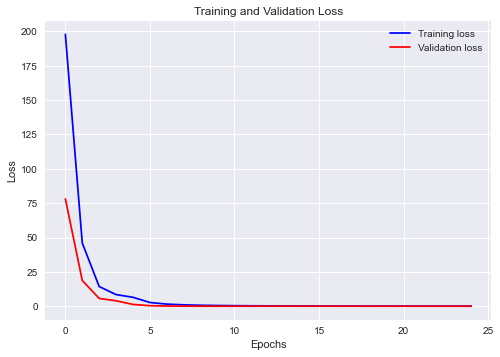

In [146]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

visualize_loss(history, "Training and Validation Loss")

In [147]:
# mean absolute error
predictions = model.predict(x_test_sequences)
meanError = np.mean(np.absolute(y_test_sequences - predictions))
meanError

0.13302854504439857

Text(0.5, 1.0, 'Prediction vs Ground truth')

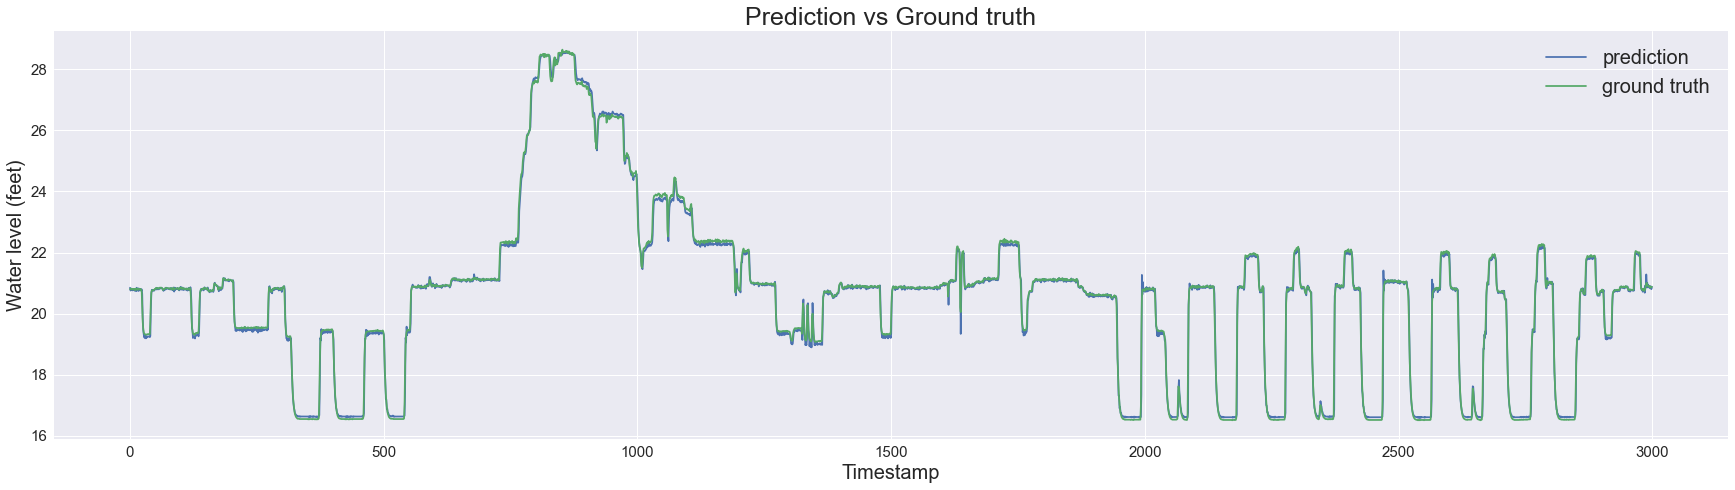

In [150]:
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(30, 7.5))
start = 6000
end = 9000
t = range(end - start)
ax.plot(t, predictions[start:end,1], label = 'prediction')
ax.plot(t, y_test_sequences[start:end,0], label = 'ground truth')
ax.set_xlabel('Timestamp', fontsize = 20)
ax.set_ylabel('Water level (feet)', fontsize = 20)
ax.legend(fontsize = 20)
ax.tick_params(axis='both', labelsize = 15)
ax.set_title('Prediction vs Ground truth', fontsize = 25)

Text(0.5, 1.0, 'Absolute error of prediction (feet)')

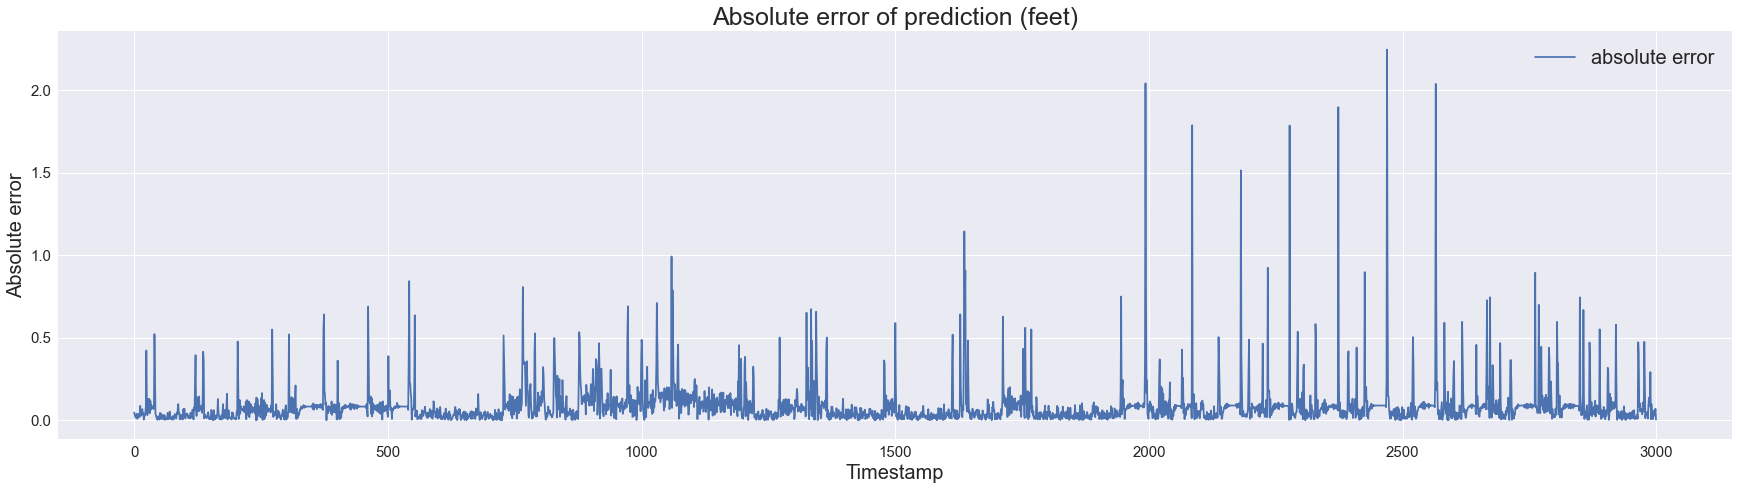

In [153]:
plt.style.use('seaborn')
fig1, ax1 = plt.subplots(figsize=(30, 7.5))
#t1 = range(predictions.shape[0])
start1 = 6000
end1 = 9000
t1 = range(end1 - start1)
ax1.plot(t1, np.absolute(predictions[:,1] - y_test_sequences[:,0])[start1:end1], label = 'absolute error')
ax1.set_xlabel('Timestamp', fontsize = 20)
ax1.set_ylabel('Absolute error', fontsize = 20)
ax1.legend(fontsize = 20)
ax1.tick_params(axis='both', labelsize = 15)
ax1.set_title('Absolute error of prediction (feet)', fontsize = 25)

Text(0.5, 1.0, 'Time of significnat water level change')

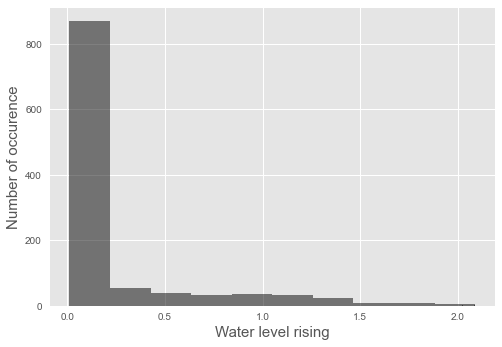

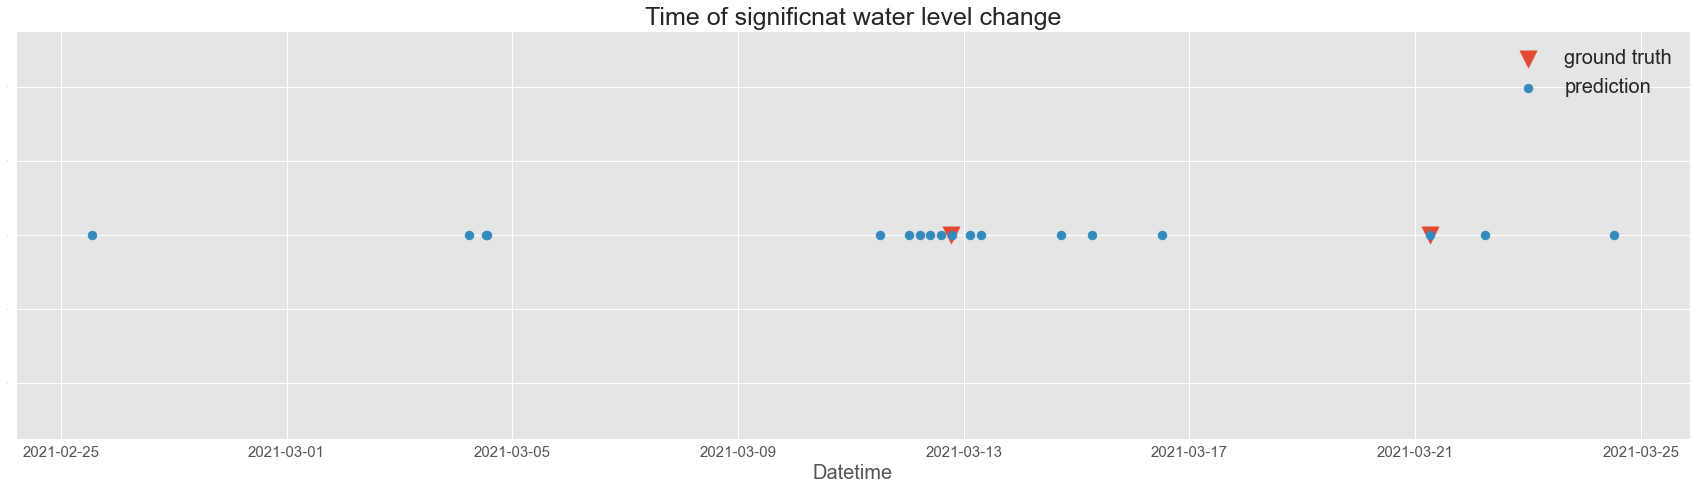

In [361]:
predict15min = predictions[:,0]
groundTruth15min = data.iloc[(train_split + val_split + past) : -1 ]

## analysis on 30min prediction
# organize data
predict30min = predictions[:,1]
groundTruth30min = data_waterLevel.iloc[(train_split + val_split + past + 1) : ]
significantAnalysis30min = pd.concat([groundTruth30min, 
                                      pd.DataFrame(predict30min, columns=["predict"], index = groundTruth30min.index)], 
                                      axis = 1)
significantAnalysis30min = significantAnalysis30min.set_index('index')
start = "2021-02-24"
end = "2021-03-24"
significantAnalysis30min = significantAnalysis30min[start: end]
significantAnalysis30min = significantAnalysis30min.reset_index()
# get the indexes of significnat changes
groundTruth_significantChange = significantAnalysis30min['value'].diff(2)
groundTruth_significantChange = groundTruth_significantChange[groundTruth_significantChange > 0]
fig = groundTruth_significantChange.hist(color = "k", alpha = 0.5, bins = 10) # for determine analysis threshold
plt.xlabel('Water level rising', fontsize = 15)
plt.ylabel('Number of occurence', fontsize = 15)
groundTruth_significantChange = groundTruth_significantChange[groundTruth_significantChange > 2]
groundTruth_significantChange.hist(color = "k", alpha = 0.5, bins = 10)

predict_significantChange = significantAnalysis30min['predict'].diff(2)
predict_significantChange = predict_significantChange[predict_significantChange > 2]

# extract data
realSignificnatChange = significantAnalysis30min.loc[groundTruth_significantChange.index].value
time_realSignificantChange = significantAnalysis30min.loc[groundTruth_significantChange.index]['index']
predictSignificnatChange = significantAnalysis30min.loc[predict_significantChange.index].predict
time_predictSignificantChange = significantAnalysis30min.loc[predict_significantChange.index]['index']

# # visualization
plt.style.use('ggplot')
fig2, ax2 = plt.subplots(figsize = (30, 7.5))
ax2.scatter(time_realSignificantChange, np.ones(time_realSignificantChange.shape), label = 'ground truth', alpha = 1, marker = 'v', s = 300)
ax2.scatter(time_predictSignificantChange, np.ones(time_predictSignificantChange.shape), label = 'prediction', alpha = 1, s = 80)
ax2.set_xlabel('Datetime', fontsize = 20)
#ax2.set_ylabel('Water level (feet)', fontsize = 20)
ax2.legend(fontsize = 20)
ax2.tick_params(axis='x', labelsize = 15)
ax2.tick_params(axis='y', labelsize = 0)
ax2.set_title('Time of significnat water level change', fontsize = 25)

In [ ]:
#